In [1]:
import pickle
from pathlib import Path

import lmdb
import matplotlib.pyplot as plt
import numpy as np
import umap

# https://realpython.com/storing-images-in-python/#reading-from-lmdb

embeddings_dir = Path(
    "/myfilestore/efs_backups/akshay/nrrd_vae_cropped_embeddings/"
    "version_8_last.lmdb"
)


In [2]:


def get_sample_at_idx(idx: int, txn: lmdb.Transaction, unpickle=True):
    sample = txn.get(str(idx).encode())

    if unpickle:
        sample = pickle.loads(sample)  # type: ignore

    return sample


lmdb_env = lmdb.open(
    str(embeddings_dir), readonly=True
)  # for async set lock=False

data = []

# Start a new read transaction
with lmdb_env.begin() as txn:

    # Encode the key the same way as we stored it

    length: int = int(txn.get(b"length"))  # type: ignore
    n_bottleneck_blocks: int = int(txn.get(b"n_bottleneck_blocks"))  # type: ignore

    print(f"dataset length {int(length)}")  # type: ignore
    print(f"n_bottleneck_blocks  {int(n_bottleneck_blocks)}")  # type: ignore

    for idx in range(length):
        sample: list = get_sample_at_idx(idx, txn)  # type: ignore
        print(
            f"sample #{idx} : {[sample[neck_idx].shape for neck_idx in range(n_bottleneck_blocks)]}"
        )
        data.append(sample)

lmdb_env.close()


dataset length 447
n_bottleneck_blocks  3
sample #0 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #1 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #2 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #3 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #4 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #5 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #6 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #7 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #8 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #9 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #10 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #11 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #12 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #13 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #14 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4, 4, 2)]
sample #15 : [(1, 64, 64, 32), (1, 16, 16, 8), (1, 4,

In [3]:
flattened_data = [
    np.asarray([d[bottle_neck_idx].flatten() for d in data], dtype=np.float64)
    for bottle_neck_idx in range(3)
]


In [4]:

from sklearn.preprocessing import StandardScaler

scaled_data = [
    StandardScaler().fit_transform(flattened_data[bottle_neck_idx])
    for bottle_neck_idx in range(3)
]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


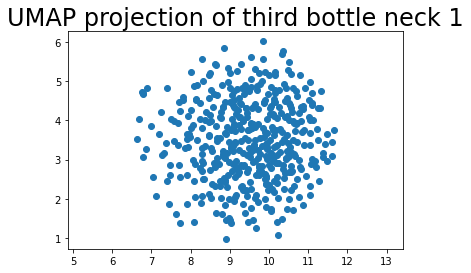

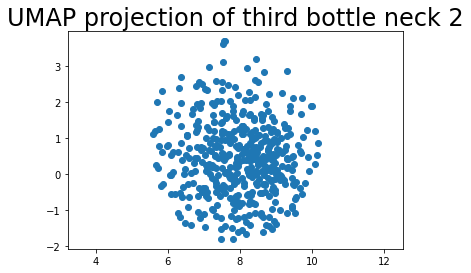

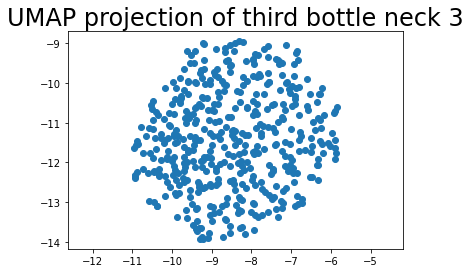

In [5]:

for bottle_neck_idx in range(3):

    reducer = umap.UMAP(random_state=22, transform_seed=22)
    embedding = reducer.fit_transform(scaled_data[bottle_neck_idx])

    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        # c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
    )
    plt.gca().set_aspect("equal", "datalim")
    plt.title(
        f"UMAP projection of third bottle neck {bottle_neck_idx+1}",
        fontsize=24,
    )
    plt.show()
